In [1]:
import pandas as pd
from typing import Optional
from pathlib import Path
import gzip
import matplotlib.pyplot as plt

# 1. Read datasets
Use the gzip function is files ar gzipped

In [2]:
def read_ds_gzip(path: Optional[Path]=None, ds: str = "TRAIN") -> pd.DataFrame:
    """Args:
        path (Optional[Path], optional): the path to read the dataset file. Defaults to /kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz.
        ds (str, optional): the part to read (TRAIN or TEST), to use when path is None. Defaults to "TRAIN".

    Returns:
        pd.DataFrame:
    """
    with gzip.open(f'/kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz' if path is None else path) as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TRAIN" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)

def read_ds(path: Optional[Path]=None, ds: str = "TRAIN"):
    """Args:
        path (Optional[Path], optional): the path to read the dataset file. Defaults to /kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz.
        ds (str, optional): the part to read (TRAIN or TEST), to use when path is None. Defaults to "TRAIN".

    Returns:
        pd.DataFrame:
    """
    with open(f'/kaggle/input/train-sc2-keystrokes/{ds}.CSV' if path is None else path) as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TRAIN" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)

In [3]:
def url_to_code(df: pd.DataFrame, col: str="battleneturl") -> None:
    """Convert url col of df to a categorical column and return the code to url dict"""
    df["battleneturl"] = pd.Categorical(df["battleneturl"])
    df["battlenetcode"] = df[[col]].apply(lambda x: x.cat.codes)
    code_to_url = dict(zip(df["battlenetcode"], df["battleneturl"]))
    df["battleneturl"] = df["battlenetcode"]
    df.drop(columns=["battlenetcode"], inplace=True)
    return code_to_url
    

In [4]:
train_ds = read_ds_gzip(Path("data/TRAIN.CSV.GZ"))
url_dict = url_to_code(train_ds)

In [5]:
train_ds.head()

,battleneturl,played_race,0,1,2,3,4,5,6,7,...,10527,10528,10529,10530,10531,10532,10533,10534,10535,10536
0,53,Protoss,Base,s,s,s,s,s,t5,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29,Protoss,s,Base,s,s,Base,s,s,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29,Protoss,Base,s,s,Base,s,s,s,t5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,53,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
test_ds = read_ds_gzip(Path("data/TEST.CSV.GZ"), ds="TEST")

In [7]:
test_ds.head()

,played_race,0,1,2,3,4,5,6,7,8,...,6807,6808,6809,6810,6811,6812,6813,6814,6815,6816
0,Zerg,s,s,s,hotkey10,s,hotkey60,s,hotkey00,s,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Terran,s,hotkey30,hotkey00,t5,s,hotkey32,s,hotkey32,s,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Protoss,Base,s,s,Base,s,hotkey20,hotkey30,hotkey60,hotkey40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Zerg,s,s,s,s,hotkey20,s,hotkey40,t5,t10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Protoss,Base,s,s,Base,s,hotkey50,hotkey30,t5,hotkey40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print(f"Train dataset shape: {train_ds.shape}, Test dataset shape: {test_ds.shape}")

Train dataset shape: (3052, 10539), Test dataset shape: (340, 6818)


# 2. Visualize the data

In [9]:
# Copy the dataset for visualization
train_ds_copy = train_ds.copy()

## 2.1 Game duration

In [10]:
def compute_durations(dataset: pd.DataFrame) -> pd.DataFrame:
    durations = []

    # Iterate over each row in the dataframe
    for _, row in dataset.iterrows():
        # Convert the row to a list (strings, possibly some NaN if missing)
        row_list = row.tolist()

        # Filter columns that start with "t" (e.g., "t10", "t120", etc.)
        time_tokens = [
            col for col in row_list if isinstance(col, str) and col.startswith("t")
        ]

        if time_tokens:
            # Get the last time token in the row
            last_time_token = time_tokens[-1]
            # Convert from e.g. "t135" -> integer 135
            duration = int(last_time_token[1:])
            durations.append(duration)
        else:
            # If no time tokens, we can append None or skip.
            durations.append(None)
    
    return durations

Number of rows with missing duration: 10


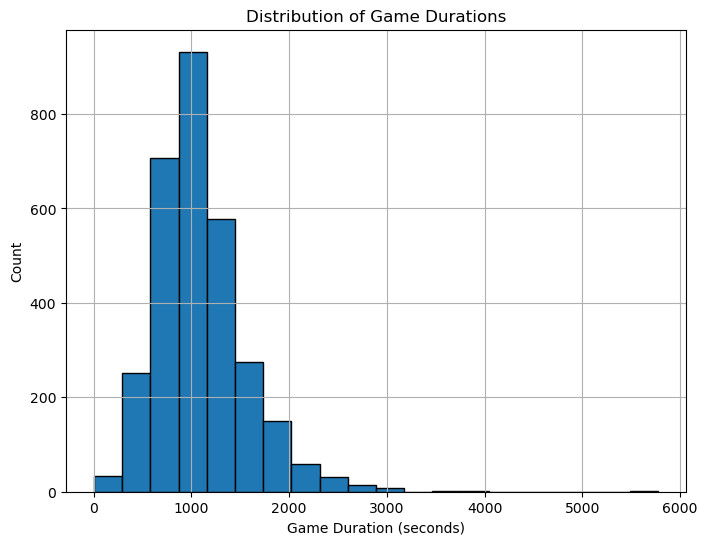

In [11]:
train_ds_copy["duration"] = compute_durations(train_ds_copy)

# Print nb of rows with missing duration
print(f"Number of rows with missing duration: {train_ds_copy['duration'].isna().sum()}")

# Drop rows without a valid duration
train_ds_copy.dropna(subset=["duration"], inplace=True)

# Plot the distribution as a histogram
plt.figure(figsize=(8, 6))
train_ds_copy["duration"].plot(kind="hist", bins=20, edgecolor="black")
plt.title("Distribution of Game Durations")
plt.xlabel("Game Duration (seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

## 2.1 Global statistics

In [12]:
# Display global statistics about the dataset
print("Total number of rows (games):", len(train_ds_copy))

# If you have a unique player identifier (e.g. 'battleneturl')
if "battleneturl" in train_ds_copy.columns:
    print("Number of unique players:", train_ds_copy["battleneturl"].nunique())

# If you have a race column (e.g. 'played_race')
if "played_race" in train_ds_copy.columns:
    print("Number of unique races:", train_ds_copy["played_race"].nunique(), "\n")
    print("=== Race Distribution ===\n", train_ds_copy["played_race"].value_counts(), "\n")

# Basic statistics for durations
if "duration" in train_ds_copy.columns:
    print("=== Duration Summary ===")
    print(train_ds_copy["duration"].agg(["min", "max", "mean", "std"]))

    # Example: Group by race to see duration stats per race
    if "played_race" in train_ds_copy.columns:
        print("\n=== Duration by Race ===")
        print(train_ds_copy.groupby("played_race")["duration"].agg(["min", "max", "mean", "std"]))


Total number of rows (games): 3042
Number of unique players: 200
Number of unique races: 3 

=== Race Distribution ===
 played_race
Protoss    1208
Zerg       1056
Terran      778
Name: count, dtype: int64 

=== Duration Summary ===
min        5.000000
max     5770.000000
mean    1092.041420
std      472.500389
Name: duration, dtype: float64

=== Duration by Race ===
              min     max         mean         std
played_race                                       
Protoss       5.0  3805.0  1051.672185  434.351665
Terran       10.0  5770.0  1148.560411  473.947642
Zerg         10.0  5770.0  1096.581439  507.945177


The most played race is Protoss, followed by Zerg and Terran. Overall the distribution is balanced.

In duration, there are outliers in the data that should be removed.

# 3. Preprocessing

## 3.1 Preprocessing functions

In [13]:
def get_dummies(df: pd.DataFrame, columns: list = ["played_race"]) -> pd.DataFrame:
    """Converts textual columns to one-hot encoded vectors (one column per possible value)"""
    df = pd.get_dummies(df, columns=columns)
    
    return df

In [14]:
def action_cols_to_list(df: pd.DataFrame, train: bool = True) -> None:
    """Converts the action columns to a list of actions column"""
    # Make a deep copy to avoid the SettingWithCopyWarning
    # df = df.copy()

    # Now safely do your assignments
    action_cols = df.columns[2 if train else 1:]
    df["actions"] = (
        df[action_cols]
        .apply(lambda row: [x for x in row if pd.notna(x)], axis=1)
    )

    df.drop(columns=action_cols, inplace=True)

In [15]:
def ceil_actions_from_duration(row) -> None:
    if "t900" in row:  # Check if "t900" exists in the actions list
        t900_index = row.index("t900")  # Find the index of "t900"
        return row[:t900_index + 1]  # Keep all actions up to and including "t900"
    return row  # If "t900" doesn't exist, keep the entire row

In [16]:
def preprocess_dataset(df: pd.DataFrame, train: bool = True) -> pd.DataFrame:
    """Preprocess the dataset"""
    processed_df = df.copy()
    action_cols_to_list(processed_df, train)
    processed_df["actions"] = processed_df["actions"].apply(ceil_actions_from_duration)

    return get_dummies(processed_df)

## 3.2 Apply preprocessing steps

In [17]:
filtered_train_ds = preprocess_dataset(train_ds)

In [ ]:
filtered_train_ds.head()

,battleneturl,actions,played_race_Protoss,played_race_Terran,played_race_Zerg
0,53,"[Base, s, s, s, s, s, t5, Base, s, hotkey30, h...",True,False,False
1,29,"[s, Base, s, s, Base, s, s, Base, s, t5, hotke...",True,False,False
2,53,"[Base, s, s, s, Base, s, hotkey30, hotkey00, t...",True,False,False
3,29,"[Base, s, s, Base, s, s, s, t5, Base, s, hotke...",True,False,False
4,53,"[Base, s, s, s, Base, s, hotkey30, hotkey00, t...",True,False,False


# 4. Feature extraction

## 4.1 Feature extraction functions

In [19]:
def chunkify_actions(action_list : list):
    """
    Given a list of actions (e.g., ["Base", "s", "s", "t5", "hotkey30", "t10", ...]),
    produce a list of tuples (start_time, end_time, actions_in_chunk).
    If we see 't5', that means the chunk boundary is 5 seconds, etc.
    """
    chunks = []
    current_time = 0
    chunk_actions = []

    def parse_time_marker(a):
        # e.g. 't5' -> int("5")
        return int(a[1:])

    for a in action_list:
        if a.startswith("t"):
            # We hit a time boundary
            end_time = parse_time_marker(a)
            if chunk_actions:
                chunks.append((current_time, end_time, chunk_actions))
            # Move forward
            current_time = end_time
            chunk_actions = []
        else:
            # It's a normal action
            chunk_actions.append(a)

    # If leftover actions exist after the last tXX
    # We'll treat them as from current_time to current_time (0-length),
    # or you can define a “max game time” if known. For now, let's store them anyway.
    if chunk_actions:
        chunks.append((current_time, current_time, chunk_actions))

    return chunks


In [20]:
def compute_features_per_chunk(chunks):
    """
    Given a list of (start_t, end_t, actions_in_chunk),
    classify them into early/mid/late, count relevant actions,
    compute average in each phase.
    """
    # Phase boundaries
    START_MAX = 60 # 1 minutes
    EARLY_MAX = 360  # 6 minutes
    MID_MAX = 900  # 15 minutes

    # We'll accumulate total counts and total durations (in seconds) for each phase
    phases = ["start", "early", "mid"]

    base_keys = {
        "hk_created": 0,
        "hk_used":    0,
        "base":       0,
        "mineral":    0,
        "other":      0
    }

    phase_counts = {
        ph: {
            **{f"hk_{i}": 0 for i in range(10)},
            **base_keys
        }
        for ph in phases
    }

    phase_durations = {ph: 0 for ph in phases}

    def get_phase(t):
        if t < START_MAX:
            return "start"
        elif t < EARLY_MAX:
            return "early"
        elif t < MID_MAX:
            return "mid"

    for start_t, end_t, acts in chunks:
        if (start_t >= MID_MAX):
            break

        # Simple approach: classify chunk by its start time (some people use midpoint)
        phase = get_phase(start_t)
        # Avoid zero durations => set it to at least 1 second
        duration = max(1, end_t - start_t)

        # Count actions in this chunk
        c_hk_pressed = {i: 0 for i in range(10)}
        c_hk_created = 0
        c_hk_used = 0
        c_base = 0
        c_mineral = 0
        c_other = 0

        for a in acts:
            if a.startswith("hotkey"):
                key = int(a[-2])
                c_hk_pressed[key] += 1
                if a.endswith("0"):
                    c_hk_created += 1
                elif a.endswith("2"):
                    c_hk_used += 1
            elif a in ["sBase", "Base"]:
                c_base += 1
            elif a in ["sMineral", "SingleMineral"]:
                c_mineral += 1
            elif a == "s":
                c_other += 1
            else:
                # some other action not relevant here
                pass

        for i in range(10):
            phase_counts[phase][f"hk_{i}"] += c_hk_pressed[i]
        phase_counts[phase]["hk_created"] += c_hk_created
        phase_counts[phase]["hk_used"] += c_hk_used
        phase_counts[phase]["base"] += c_base
        phase_counts[phase]["mineral"] += c_mineral
        phase_counts[phase]["other"] += c_other

        phase_durations[phase] += duration

    # Now compute the final average for each phase
    # e.g.  (count / total_duration_in_phase)
    feats = {}
    for phase in phases:
        dur = phase_durations[phase]
        pc = phase_counts[phase]
        if dur == 0:
            for i in range(10):
                feats[f"{phase}_hk_{i}"] = 0
            feats[f"{phase}_hk_created"] = 0
            feats[f"{phase}_hk_used"] = 0
            feats[f"{phase}_base"] = 0
            feats[f"{phase}_mineral"] = 0
            feats[f"{phase}_other"] = 0
        else:
            for i in range(10):
                feats[f"{phase}_hk_{i}"] = (pc[f"hk_{i}"] / dur)
            feats[f"{phase}_hk_created"] = (pc["hk_created"] / dur)
            feats[f"{phase}_hk_used"] = (pc["hk_used"] / dur)
            feats[f"{phase}_base"] = (pc["base"] / dur)
            feats[f"{phase}_mineral"] = (pc["mineral"] / dur)
            feats[f"{phase}_other"] = (pc["other"] / dur)

    return feats

In [21]:
def compute_all_features(row):
   """
   row is a single Pandas row with:
      row["actions"] = list of action strings
      row["battleneturl"], row["played_race"], etc. if needed
   Returns a dict of feature_name -> value
   """
   chunks = chunkify_actions(row)
   feats = compute_features_per_chunk(chunks)
   
   # You can also include the player's ID or race in the returned features if desired
   return feats

In [22]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    features_df = df["actions"].apply(compute_all_features).apply(pd.Series)

    # Combine with the original df if you like
    combined_df = pd.concat([df, features_df], axis=1)
    
    # Drop the actions column
    combined_df.drop(columns=["actions"], inplace=True)
    
    return combined_df

## 4.2 Apply feature extraction steps

In [23]:
# Apply to entire DataFrame
final_train_ds = add_features(filtered_train_ds)

print(final_train_ds.columns)

Index(['battleneturl', 'played_race_Protoss', 'played_race_Terran',
       'played_race_Zerg', 'start_hk_0', 'start_hk_1', 'start_hk_2',
       'start_hk_3', 'start_hk_4', 'start_hk_5', 'start_hk_6', 'start_hk_7',
       'start_hk_8', 'start_hk_9', 'start_hk_created', 'start_hk_used',
       'start_base', 'start_mineral', 'start_other', 'early_hk_0',
       'early_hk_1', 'early_hk_2', 'early_hk_3', 'early_hk_4', 'early_hk_5',
       'early_hk_6', 'early_hk_7', 'early_hk_8', 'early_hk_9',
       'early_hk_created', 'early_hk_used', 'early_base', 'early_mineral',
       'early_other', 'mid_hk_0', 'mid_hk_1', 'mid_hk_2', 'mid_hk_3',
       'mid_hk_4', 'mid_hk_5', 'mid_hk_6', 'mid_hk_7', 'mid_hk_8', 'mid_hk_9',
       'mid_hk_created', 'mid_hk_used', 'mid_base', 'mid_mineral',
       'mid_other'],
      dtype='object')


In [24]:
label_col = "battleneturl"
feature_cols = [c for c in final_train_ds.columns if c != label_col]

# 5. Training

In [25]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pickle

In [26]:
print("Features:", feature_cols)
X = final_train_ds[feature_cols]
y = final_train_ds[label_col].values

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

Features: ['played_race_Protoss', 'played_race_Terran', 'played_race_Zerg', 'start_hk_0', 'start_hk_1', 'start_hk_2', 'start_hk_3', 'start_hk_4', 'start_hk_5', 'start_hk_6', 'start_hk_7', 'start_hk_8', 'start_hk_9', 'start_hk_created', 'start_hk_used', 'start_base', 'start_mineral', 'start_other', 'early_hk_0', 'early_hk_1', 'early_hk_2', 'early_hk_3', 'early_hk_4', 'early_hk_5', 'early_hk_6', 'early_hk_7', 'early_hk_8', 'early_hk_9', 'early_hk_created', 'early_hk_used', 'early_base', 'early_mineral', 'early_other', 'mid_hk_0', 'mid_hk_1', 'mid_hk_2', 'mid_hk_3', 'mid_hk_4', 'mid_hk_5', 'mid_hk_6', 'mid_hk_7', 'mid_hk_8', 'mid_hk_9', 'mid_hk_created', 'mid_hk_used', 'mid_base', 'mid_mineral', 'mid_other']


In [27]:
param_distributions = {
    'logreg__penalty': ['l2', 'l1'],
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],   # sample in log-scale
    'logreg__solver': ['liblinear', 'saga']       # both can handle l1 or l2
}

In [28]:
pipe = Pipeline([
    ('scaler', StandardScaler()),             # Standardize features
    ('logreg', LogisticRegression())          # Our linear classifier
])

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=30,               # how many parameter samples to draw
    scoring='accuracy',      # or 'f1', 'f1_macro', etc. if more appropriate
    cv=5,                    # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,               # use all CPU cores
    random_state=42
)

In [29]:
random_search.fit(X_train, y_train)

# Best parameters from cross-validation
print("Best Params:", random_search.best_params_)

# Best cross-validation score
print("Best CV Accuracy:", random_search.best_score_)

# Evaluate on the test set
best_logreg_model = random_search.best_estimator_
y_pred = best_logreg_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best Params: {'logreg__solver': 'liblinear', 'logreg__penalty': 'l2', 'logreg__C': 10}
Best CV Accuracy: 0.8955362231385564
Test Accuracy: 0.9230769230769231


In [30]:
# Save the model
with open("./resources/lr-model.pkl", "wb") as f:
    pickle.dump(best_logreg_model, f)

# 6. Submission

In [31]:
# Load the model
with open("./resources/lr-model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [32]:
filtered_test_ds = preprocess_dataset(test_ds, train=False)
print(filtered_test_ds.head(), filtered_test_ds.shape, sep="\n")
assert filtered_test_ds.shape[0] == test_ds.shape[0], "Number of rows changed after preprocessing!"

                                             actions  played_race_Protoss  \
0  [s, s, s, hotkey10, s, hotkey60, s, hotkey00, ...                False   
1  [s, hotkey30, hotkey00, t5, s, hotkey32, s, ho...                False   
2  [Base, s, s, Base, s, hotkey20, hotkey30, hotk...                 True   
3  [s, s, s, s, hotkey20, s, hotkey40, t5, t10, h...                False   
4  [Base, s, s, Base, s, hotkey50, hotkey30, t5, ...                 True   

   played_race_Terran  played_race_Zerg  
0               False              True  
1                True             False  
2               False             False  
3               False              True  
4               False             False  
(340, 4)


In [33]:
final_test_ds = add_features(filtered_test_ds)
print(final_test_ds.head(), final_test_ds.shape, sep="\n")
assert final_test_ds.shape[0] == test_ds.shape[0], "Number of rows changed after adding features!"

   played_race_Protoss  played_race_Terran  played_race_Zerg  start_hk_0  \
0                False               False              True    1.416667   
1                False                True             False    0.018182   
2                 True               False             False    0.000000   
3                False               False              True    0.000000   
4                 True               False             False    0.000000   

   start_hk_1  start_hk_2  start_hk_3  start_hk_4  start_hk_5  start_hk_6  \
0    0.050000    0.083333    0.000000    0.000000    0.000000    1.500000   
1    0.218182    0.018182    1.036364    0.000000    0.000000    0.000000   
2    0.000000    0.300000    0.166667    0.016667    0.000000    1.283333   
3    0.000000    0.254545    0.000000    0.618182    0.000000    0.000000   
4    0.000000    0.000000    0.016667    0.016667    0.333333    0.000000   

   ...  mid_hk_5  mid_hk_6  mid_hk_7  mid_hk_8  mid_hk_9  mid_hk_created  \
0  .

In [34]:
predictions = loaded_model.predict(final_test_ds[feature_cols])

In [35]:
# Convert the array of codes to URLs using the url_dict
urls = [url_dict[code] for code in predictions]

# Create a new DataFrame with these URLs
urls_df = pd.DataFrame(urls, columns=['prediction'])

# Add a 'RowId' column starting at index 1
urls_df['RowId'] = range(1, len(urls_df) + 1)

# Set 'RowId' as the index
urls_df.set_index('RowId', inplace=True)

# Display the new DataFrame
print(urls_df.head())

                                              prediction
RowId                                                   
1      http://eu.battle.net/sc2/en/profile/3538115/1/...
2      http://eu.battle.net/sc2/en/profile/2896854/1/...
3      http://eu.battle.net/sc2/en/profile/3973341/1/...
4      http://eu.battle.net/sc2/en/profile/250458/1/V...
5      http://eu.battle.net/sc2/en/profile/950504/1/G...


In [36]:
urls_df.to_csv('submission.csv')

# 7. Evaluation

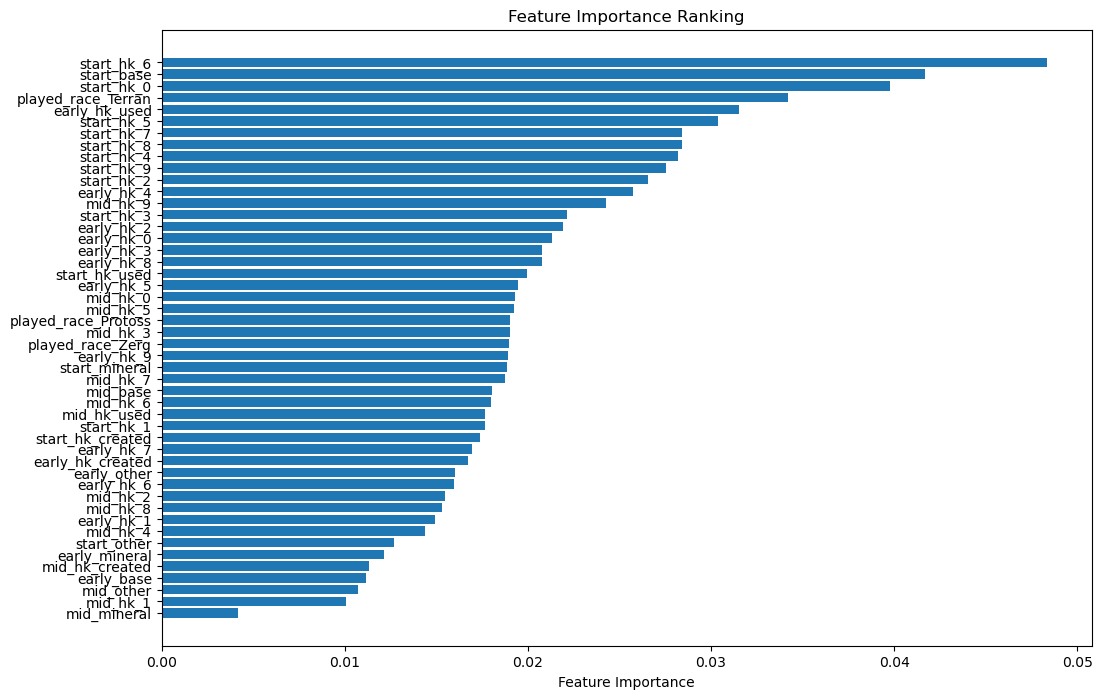

In [44]:
# Feature Importance - Mean Decrease in Impurity
importances = loaded_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot Mean Decrease in Impurity
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis()
plt.show()

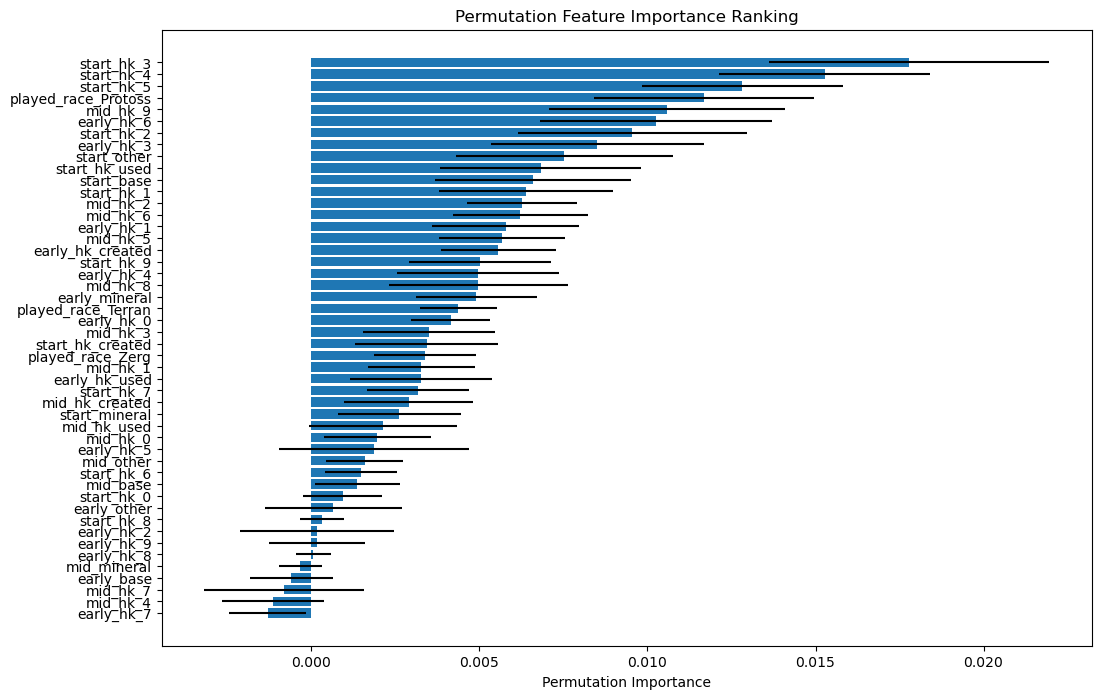

In [68]:
from sklearn.inspection import permutation_importance


# Permutation Importance
results = permutation_importance(loaded_model, X_test, y_test, scoring='accuracy', n_repeats=30, random_state=42, n_jobs=-1)

perm_importance = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std
}).sort_values(by='importance_mean', ascending=False)

# Plot Permutation Importance
plt.figure(figsize=(12, 8))
plt.barh(perm_importance['feature'], perm_importance['importance_mean'], xerr=perm_importance['importance_std'])
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance Ranking')
plt.gca().invert_yaxis()
plt.show()
